# 01 : Introduction to imaging in astronomy

In Astronomy, when we observe the sky, we are not only interested in the position of the objects, but also in their brightness, colors etc. This is why we need to be able to measure the flux of the objects. But, when we observe the sky, we do not measure the flux of the objects directly. We measure the number of photons that hit the detector. The flux is then derived from the number of photons. This is why we need to understand how the photons are detected and how we can convert the number of photons into a flux. THis process is called the calibration / Reduction of an astronomical image (from an image, we want data ! ).

### This course is based on the Astropy Learning Courses ; http://www.astropy.org/ccd-reduction-and-photometry-guide/v/dev/notebooks/00-00-Preface.html

### PLEASE READ IT FOR MORE DETAILS :-)

# Understanding an astronomical CCD image
An astronomical image like the one shown below is essentially a two-dimensional
array of values. In an ideal world, the value of each pixel (a pixel being one
element of the array) would be directly proportional to the amount of light that
fell on the pixel during the time the camera's shutter was open.

But the ideal scenario does not in fact hold true. A solid understanding of
*why* pixel values are not directly proportional to light is useful before
diving into the details of image reduction.
## Counts, photons, and electrons

The number stored in a raw astronomical image straight off a telescope is called
an Analog Digital Unit (ADU) or count, because internally the camera converts
the analog voltage in each pixel to a numerical count. The counts of interest to
an astronomer are the ones generated via the photoelectric effect when a photon
hits the detector. The number of photons (or equivalently, electrons) that reach
the pixel is related to the counts in the pixel by the gain.

The gain is typically provided by the manufacturer of the camera and can be
measured from a combination of bias and flat images (Howell 2002; p. 71).

**Take note** that trying to convert a raw image count to photons/electrons by
multiplying by the gain will not be meaningful because the raw counts include
contributions from sources other than light.
## Not all counts are (interesting) light

There are several contributions to the counts in a pixel. Image reduction is
essentially the process of removing all of these except those due to light from
an astronomical object:

+ An offset voltage called **bias** is applied to the CCD chip to ensure there
are no negative counts during readout. There are small variations in the value
of the bias across the chip, and there can be small variations in the bias level
over time.
+ Counts can be generated in a pixel due to thermal motion of electrons in CCD;
cooling a CCD reduces, but may not fully eliminate, this **dark current**. In
modern CCDs the dark current is often ignorable exept for a small fraction of
pixels. Dark current is typically reported in electrons/second/pixel, and
depends strongly on temperature.
+ There is **read noise** intrinsic to the electronics of the CCD. It is
impossible to eliminate this noise (it's present in every image taken by the
camera) but there are approaches to minimizing it. Read noise is typically
reported in electrons as it can depend on temperature.
+ Some light received by the telescope is scattered light coming from the night
sky. The amount of **sky background** depends on the filter passband, the
atmospheric conditions, and the local light sources.
+ Though a CCD chip is fairly small, it's not unsual for **cosmic rays** to hit
the chip, releasing charge that is then converted to counts.

Whatever remains after taking all of those things away is, in principle, light
from astronomical sources.

In practice, there are additional complications.
## CCDs are not perfect

There are a number of issues that affect the sensitivity of the CCD to light,
some of which can be corrected for and some of which cannot.

+ Vignetting, a darkening of the images in the corners, is common and
correctable.
+ Dust in the optical path, which causes "donuts" or "worms" on the image, is
also common and correctable.
+ Variations in the sensitivity of individual pixels are also common and
correctable.
+ Dead pixels, which are pixels that don't respond to light, cannot be corrected
for.

**Flat** corrections attempt to remove many of these effects. The idea is to
image something which is uniformly illuminated as a way to measure variations in
sensitivity (regardless of cause) and compensate for them.
## References

Howell, S., *Handbook of CCD Astronomy*, Second Ed, Cambridge University Press
2006

## Structure of an image in astronomy

At the end of the day,  an astronomical image has the following structure : 

$$
\text{raw image} = \text{bias} + \text{noise} + \text{dark current} + \text{flat} \times (\text{sky} + \text{stars}).
$$

Solving for the counts just from the stars is as follows:

$$
\text{stars} + \text{noise} = \frac{\text{raw image} - \text{bias} - \text{dark current}}{\text{flat}} - \text{sky}
$$

**It is *impossible* to remove the noise from the raw image because the noise is
random.**

# Let's study the calibration images ! 

In [2]:
from pathlib import Path
from astropy.nddata import CCDData
from astropy.io import fits
from astropy.stats import mad_std
import ccdproc as ccdp
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Silence FITSFixedWarning : 
import warnings
from astropy.utils.exceptions import AstropyWarning
from astropy.wcs import FITSFixedWarning
warnings.simplefilter('ignore', category=FITSFixedWarning)
warnings.simplefilter('ignore', category=AstropyWarning)

In [4]:
import sys, os

# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__

In [5]:
# What is the pathes to your images? 
data_dir= Path("Data")
dark_dir = data_dir / "dark"

calibration_dir = Path("Calibration-masters")
# List the files : 
dark_files = list(dark_dir.glob("*.fits"))
# Open the first one, and display the header : 
with fits.open(dark_files[0]) as hdul:
    hdul.info()
    print(repr(hdul[0].header))

Filename: Data/dark/dark-0.5-8.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      67   (4784, 3194)   float32   
SIMPLE  =                    T /FITS header                                     
BITPIX  =                  -32 /No.Bits per pixel                               
NAXIS   =                    2 /No.dimensions                                   
NAXIS1  =                 4784 /Length X axis                                   
NAXIS2  =                 3194 /Length Y axis                                   
DATE    = '2024-01-30T22:19:50.671300' /Date of FITS file creation              
SWCREATE= 'PRISM,  Version  11.4.13.28,  01/07/2023' /Software Name and version 
ORIGIN  = 'Observatoire du Pic du Midi' /Origin place of FITS image             
SITELAT = '+42:56:13:00      ' /Latitude observatory                            
SITELONG= '+00:08:41:99      ' /Longitude observatory                           
DATE-OBS= '2024-01-30T22

In [6]:
# List all images in dark using ccdproc : 
dark_list = ccdp.ImageFileCollection(dark_dir)

/home/travinet/bin/miniforge3/envs/splat39/lib/python3.9/site-packages/ccdproc/image_collection.py:548: UserWarning: Header from file "Data/dark/dark-0.001-1.fits" contains multiple entries for "date", the pair "date=30/01/2024" will be ignored.
  warnings.warn(
/home/travinet/bin/miniforge3/envs/splat39/lib/python3.9/site-packages/ccdproc/image_collection.py:548: UserWarning: Header from file "Data/dark/dark-0.001-1.fits" contains multiple entries for "instrume", the pair "instrume=ZWO ASI6200MM Pro" will be ignored.
  warnings.warn(
/home/travinet/bin/miniforge3/envs/splat39/lib/python3.9/site-packages/ccdproc/image_collection.py:548: UserWarning: Header from file "Data/dark/dark-0.001-1.fits" contains multiple entries for "ccd-temp", the pair "ccd-temp=-20.3" will be ignored.
  warnings.warn(
/home/travinet/bin/miniforge3/envs/splat39/lib/python3.9/site-packages/ccdproc/image_collection.py:548: UserWarning: Header from file "Data/dark/dark-0.001-10.fits" contains multiple entries fo

In [7]:
dark_list.summary['file', 'exptime']

file,exptime
str18,float64
dark-0.001-1.fits,0.001
dark-0.001-10.fits,0.001
dark-0.001-2.fits,0.001
dark-0.001-3.fits,0.001
dark-0.001-4.fits,0.001
dark-0.001-5.fits,0.001
dark-0.001-6.fits,0.001
dark-0.001-7.fits,0.001
dark-0.001-8.fits,0.001


In [6]:
# List unique exposure times :
unique_exptime = np.array(np.unique(dark_list.summary['exptime']))
print(unique_exptime)
# Filter by exposure time, only keenp files that have 1e-3 exposure time -> These are the bias frames
bias_files = dark_list.files_filtered(exptime=unique_exptime[0])

# Open the bias files and combine them :
bias_list = []
for file in bias_files:
    pathtobias = dark_dir / file
    ccd = CCDData.read(pathtobias, unit="adu")
    bias_list.append(ccd)

INFO:astropy:An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.

INFO:astropy:An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.

INFO:astropy:An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.

INFO:astropy:An exception happened while extracting WCS information from the Header.


[1.e-03 1.e-02 1.e-01 2.e-01 5.e-01 1.e+00 2.e+00]
INFO: An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.
 [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.
 [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.
 [astr

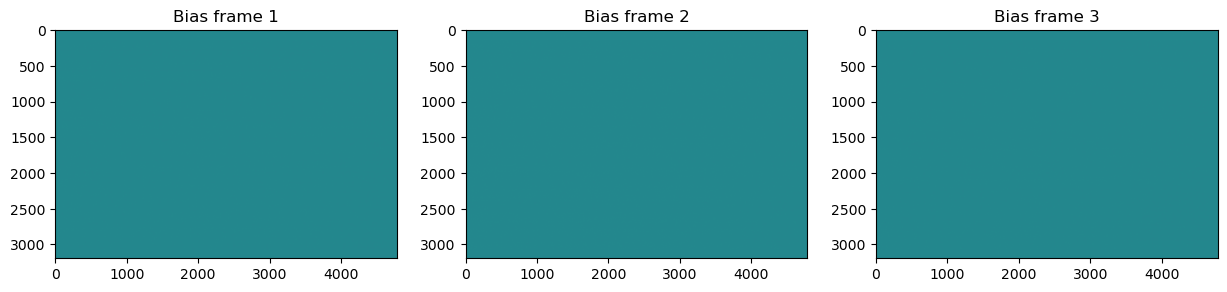

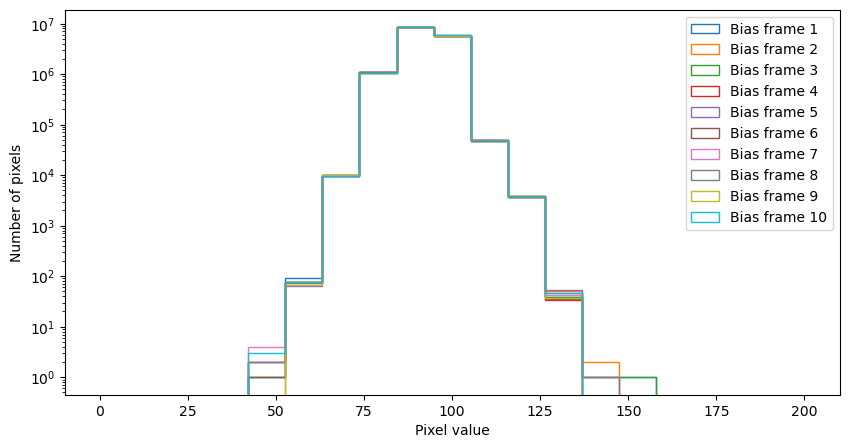

In [7]:
# Plot the bias frames :
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, ccd in enumerate(bias_list[:3]):
    ax[i].imshow(ccd, vmin=0, vmax=200)
    ax[i].set_title(f"Bias frame {i+1}")
plt.show()
# Nicely uniform right? 
# Plot their histograms on the same figure : 
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
bins = np.linspace(0, 200, 20)
for i, ccd in enumerate(bias_list):
    ax.hist(ccd.data.flatten(), bins=bins, histtype="step", label=f"Bias frame {i+1}")
ax.set_xlabel("Pixel value")
ax.set_ylabel("Number of pixels")
ax.set_yscale("log")
ax.legend()
plt.show()

In [8]:
# Combine the bias frames -> It will be bias + RON (Read Out Noise) master : 
master_bias = ccdp.combine(bias_list, method="average", sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5, 
                           sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std)

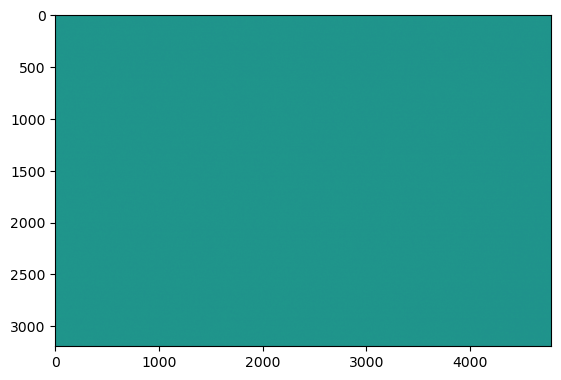

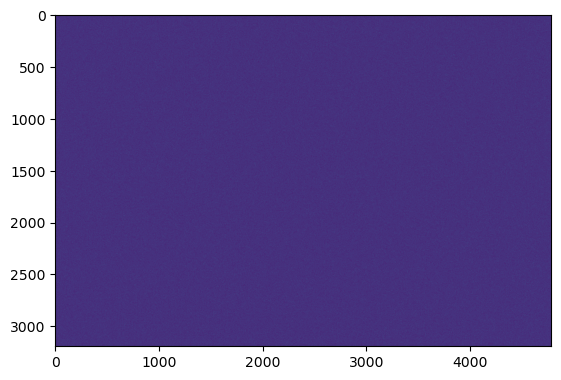

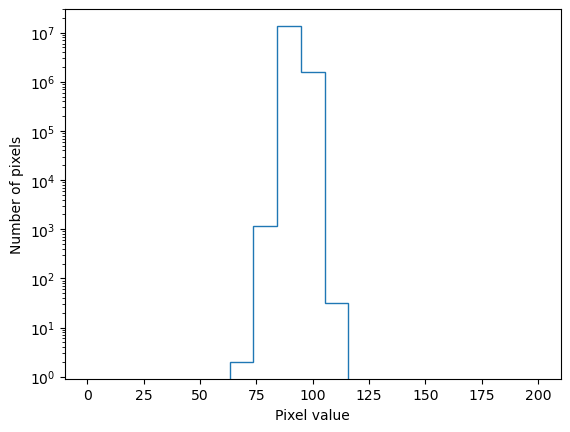

In [9]:
plt.imshow(master_bias)
plt.show()
plt.imshow(master_bias.uncertainty.array)
plt.show()
plt.hist(master_bias.data.flatten(), bins=bins, histtype="step")
plt.xlabel("Pixel value")
plt.ylabel("Number of pixels")
plt.yscale("log")
plt.show()
# Save the master bias :
master_bias.write(calibration_dir / "master_bias.fits", overwrite=True)

In [10]:
# Now, we load the dark frames with different exposure times, in a dictionary with their exposure time as key :
dark_dict = {}
for exptime in unique_exptime[1:]:
    dark_files = dark_list.files_filtered(exptime=exptime)
    temp_dark_list = []
    for file in dark_files:
        pathtodark = dark_dir / file
        ccd = CCDData.read(pathtodark, unit="adu")
        temp_dark_list.append(ccd)
    dark_dict[exptime] = temp_dark_list

INFO:astropy:An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.

INFO:astropy:An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.

INFO:astropy:An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.

INFO:astropy:An exception happened while extracting WCS information from the Header.


INFO: An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.
 [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.
 [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.
 [astropy.nddata.ccddata]
INFO: An exception happened whi

INFO:astropy:An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.

INFO:astropy:An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.

INFO:astropy:An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.

INFO:astropy:An exception happened while extracting WCS information from the Header.


INFO: An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.
 [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.
 [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.
 [astropy.nddata.ccddata]
INFO: An exception happened whi

INFO:astropy:An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.

INFO:astropy:An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.

INFO:astropy:An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.

INFO:astropy:An exception happened while extracting WCS information from the Header.


INFO: An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.
 [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.
 [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.
 [astropy.nddata.ccddata]


In [12]:
# Go through the dictionary and combine the dark frames :
dark_combined_dict = {}
for exptime, dark_list in dark_dict.items():
    dark_combined_dict[exptime] = ccdp.combine(dark_list, method="average", sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5, 
                                               sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std)

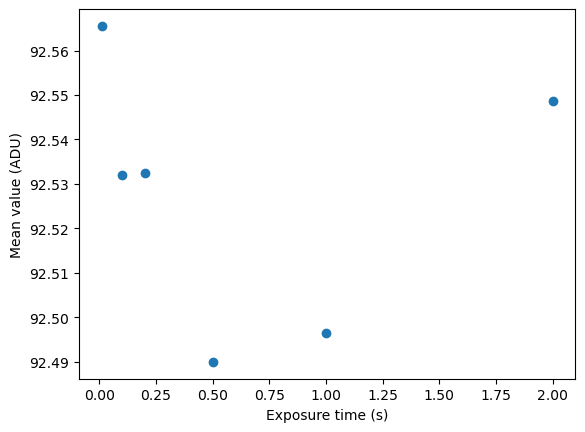

In [13]:
# Get the master darks mean values and plot them in function of exptime :
dark_mean = []
exp_list = []
for exptime, dark in dark_combined_dict.items():
    dark_mean.append(np.mean(dark.data))
    exp_list.append(exptime)

plt.plot(exp_list, dark_mean, "o")
plt.xlabel("Exposure time (s)")
plt.ylabel("Mean value (ADU)")
plt.show()



# Do we need darks ?

In [8]:
# Now, we treat the FLAT frames : 
flat_dir = data_dir / "FLATS"
master_bias = CCDData.read(calibration_dir / "master_bias.fits", unit="adu")
flat_list = ccdp.ImageFileCollection(flat_dir)

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.



INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.
 [astropy.nddata.ccddata]


/home/travinet/bin/miniforge3/envs/splat39/lib/python3.9/site-packages/ccdproc/image_collection.py:548: UserWarning: Header from file "Data/FLATS/flat_G'2-23.fits" contains multiple entries for "date", the pair "date=30/01/2024" will be ignored.
  warnings.warn(
/home/travinet/bin/miniforge3/envs/splat39/lib/python3.9/site-packages/ccdproc/image_collection.py:548: UserWarning: Header from file "Data/FLATS/flat_G'2-23.fits" contains multiple entries for "instrume", the pair "instrume=ZWO ASI6200MM Pro" will be ignored.
  warnings.warn(
/home/travinet/bin/miniforge3/envs/splat39/lib/python3.9/site-packages/ccdproc/image_collection.py:548: UserWarning: Header from file "Data/FLATS/flat_G'2-23.fits" contains multiple entries for "ccd-temp", the pair "ccd-temp=-20.8" will be ignored.
  warnings.warn(
/home/travinet/bin/miniforge3/envs/splat39/lib/python3.9/site-packages/ccdproc/image_collection.py:548: UserWarning: Header from file "Data/FLATS/flat_G'2-24.fits" contains multiple entries for

In [9]:
# List unique filters :
unique_filters = np.array(np.unique(flat_list.summary['filters']))
flat_list.summary['file', 'exptime', 'filters']

file,exptime,filters
str19,float64,str6
flat_G'2-23.fits,0.25,g'2
flat_G'2-24.fits,0.25,g'2
flat_G'2-25.fits,0.25,g'2
flat_G'2-26.fits,0.25,g'2
flat_G'2-27.fits,0.25,g'2
flat_G'2-28.fits,0.25,g'2
flat_G'2-29.fits,0.25,g'2
flat_G'2-30.fits,0.25,g'2
flat_G'2-31.fits,0.25,g'2


In [10]:
def inv_median(array):
    return 1 / np.median(array)

INFO:astropy:An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.



INFO:astropy:An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.

INFO:astropy:An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.

INFO:astropy:An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.

INFO:astropy:An exception happened while extracting WCS information from the Header.


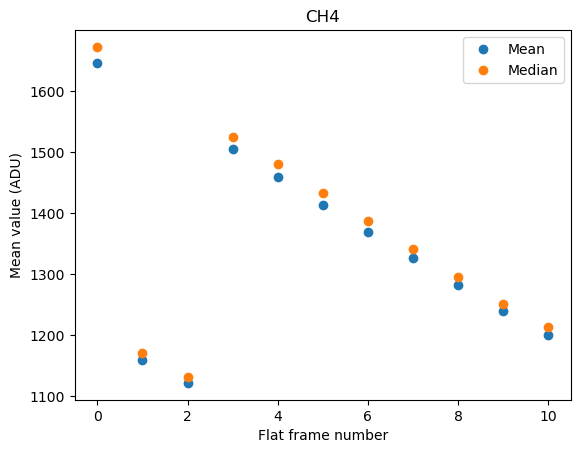

INFO:astropy:splitting each image into 15 chunks to limit memory usage to 500000000.0 bytes.
/home/travinet/bin/miniforge3/envs/splat39/lib/python3.9/site-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


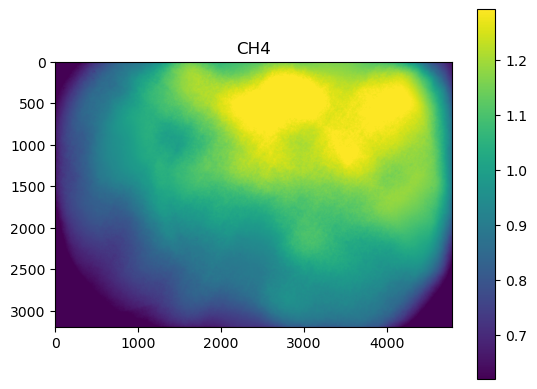

INFO:astropy:An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.

INFO:astropy:An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.

INFO:astropy:An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.

INFO:astropy:An exception happened while extracting WCS information from the Header.


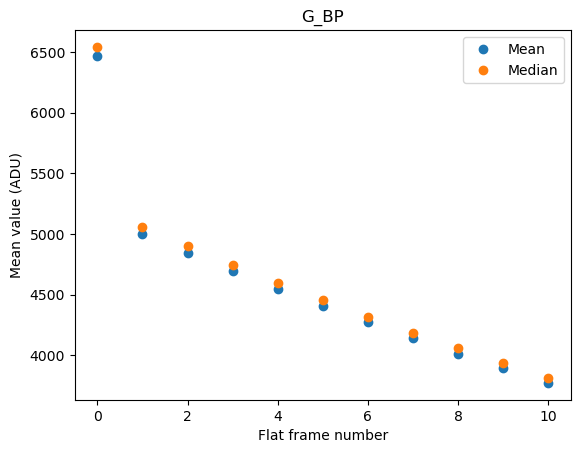

INFO:astropy:splitting each image into 15 chunks to limit memory usage to 500000000.0 bytes.
/home/travinet/bin/miniforge3/envs/splat39/lib/python3.9/site-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


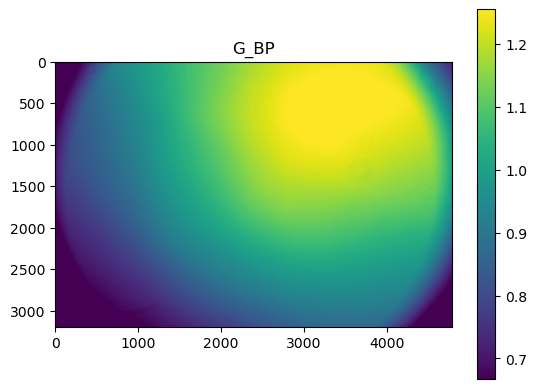

INFO:astropy:An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.

INFO:astropy:An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.

INFO:astropy:An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.

INFO:astropy:An exception happened while extracting WCS information from the Header.


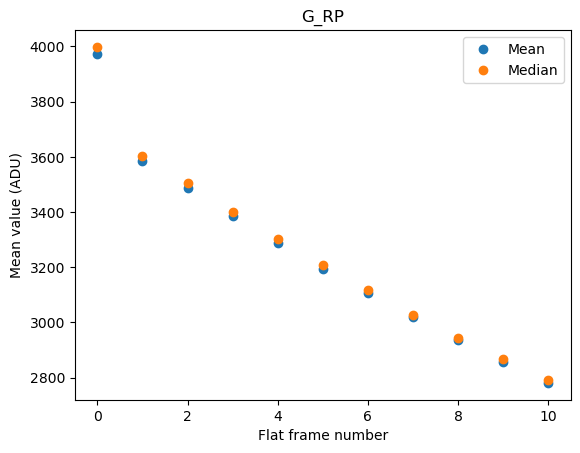

INFO:astropy:splitting each image into 15 chunks to limit memory usage to 500000000.0 bytes.
/home/travinet/bin/miniforge3/envs/splat39/lib/python3.9/site-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


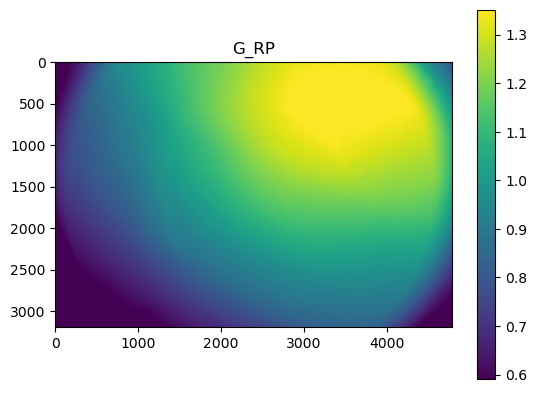

INFO:astropy:An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.

INFO:astropy:An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.

INFO:astropy:An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.

INFO:astropy:An exception happened while extracting WCS information from the Header.


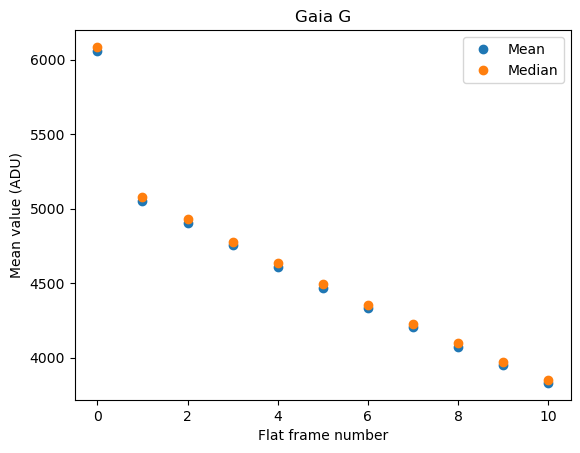

INFO:astropy:splitting each image into 15 chunks to limit memory usage to 500000000.0 bytes.
/home/travinet/bin/miniforge3/envs/splat39/lib/python3.9/site-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


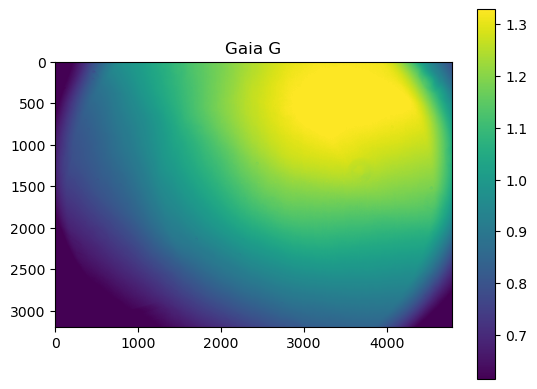

INFO:astropy:An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.

INFO:astropy:An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.

INFO:astropy:An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.

INFO:astropy:An exception happened while extracting WCS information from the Header.


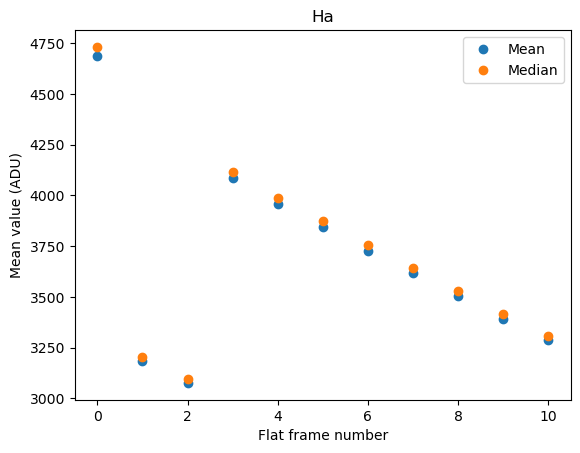

INFO:astropy:splitting each image into 15 chunks to limit memory usage to 500000000.0 bytes.
/home/travinet/bin/miniforge3/envs/splat39/lib/python3.9/site-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


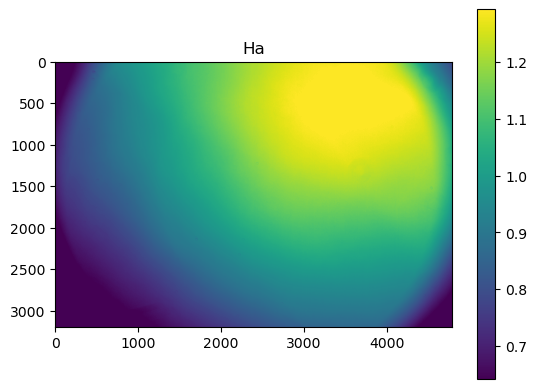

INFO:astropy:An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.

INFO:astropy:An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.

INFO:astropy:An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.

INFO:astropy:An exception happened while extracting WCS information from the Header.


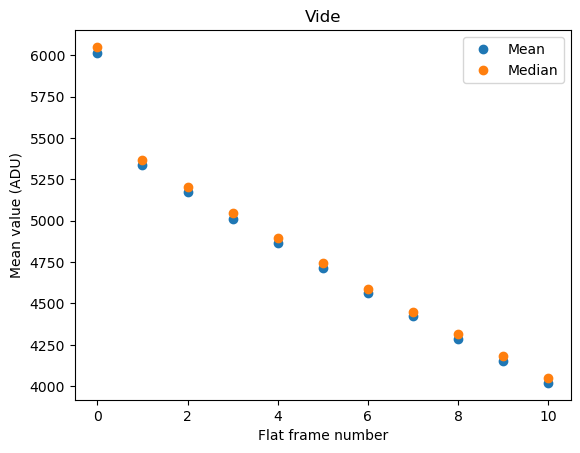

INFO:astropy:splitting each image into 15 chunks to limit memory usage to 500000000.0 bytes.
/home/travinet/bin/miniforge3/envs/splat39/lib/python3.9/site-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


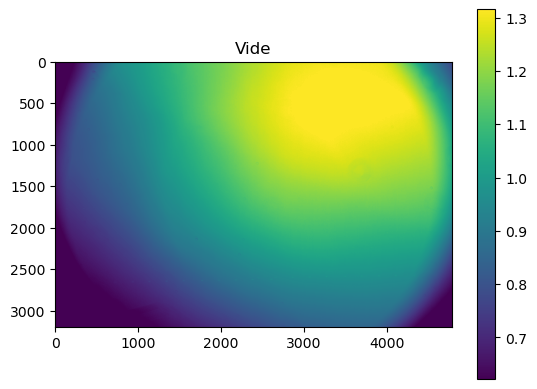

INFO:astropy:An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.

INFO:astropy:An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.

INFO:astropy:An exception happened while extracting WCS information from the Header.
SingularMatrixError: ERROR 3 in wcsset() at line 2808 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 718 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.

INFO:astropy:An exception happened while extracting WCS information from the Header.


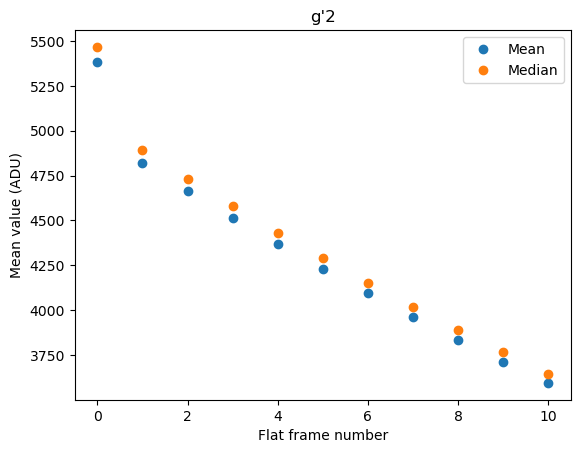

INFO:astropy:splitting each image into 15 chunks to limit memory usage to 500000000.0 bytes.
/home/travinet/bin/miniforge3/envs/splat39/lib/python3.9/site-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


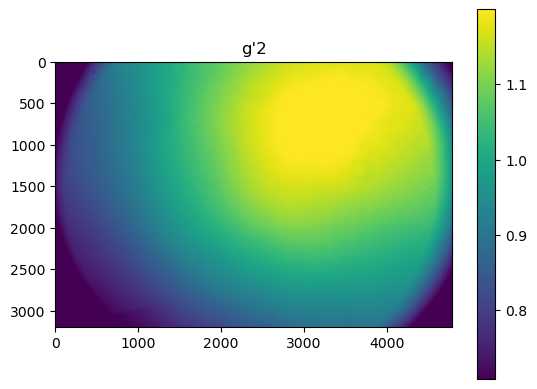

In [14]:

# Create a dictionary with the filters as keys :
flat_dict = {}
for filt in unique_filters[:]:
    print(filt)
    flat_files = flat_list.files_filtered(filters=filt)
    temp_flat_list = []
    flat_mean = []
    flat_median = []
    blockPrint()
    for file in flat_files:
        pathtoflat = flat_dir / file
        nccd = CCDData.read(pathtoflat, unit="adu")
        # break
        # Substract the master bias from the flat frames :
        nccd = ccdp.subtract_bias(nccd, master_bias)
        temp_flat_list.append(nccd)
        flat_mean.append(np.mean(nccd.data))
        flat_median.append(np.median(nccd.data))
    enablePrint()
    # Plot the mean and median values of the flat frames :
    plt.plot(flat_mean, "o", label="Mean")
    plt.plot(flat_median, "o", label="Median")
    plt.xlabel("Flat frame number")
    plt.ylabel("Mean value (ADU)")
    plt.title(filt)
    plt.legend()
    plt.show()
    # Combine the flat frames :
    flat_dict[filt] = ccdp.combine(temp_flat_list, method="average", sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5, 
                                   sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, scale=inv_median, mem_limit=500e6)
    # Add the filter name to the header :
    flat_dict[filt].header["FILTER"] = filt
    # Save the master flat :
    flat_dict[filt].write(calibration_dir / f"master_flat_{filt}.fits", overwrite=True)
    # Plot the master flat :
    plt.imshow(flat_dict[filt], vmin = np.percentile(flat_dict[filt], 5), vmax = np.percentile(flat_dict[filt], 95))
    plt.colorbar()
    plt.title(filt)
    plt.show()

In [47]:
# For the first filter, get the mean value of the flat frames : 
flat_mean = []
for flat in flat_dict[unique_filters[1]]:
    flat_mean.append(np.mean(flat.data))

plt.plot(flat_mean, "o")
plt.xlabel("Flat frame number")
plt.ylabel("Mean value (ADU)")
plt.show()

KeyError: 'G_BP'

In [28]:
ccd.

AttributeError: 'CCDData' object has no attribute 'filename'

In [22]:
flat_dict

{'CH4': [],
 'G_BP': [],
 'G_RP': [],
 'Gaia G': [],
 'Ha': [],
 'Vide': [],
 "g'2": []}

# Explain what is a dark + bias; why we don't necessarily use it - take and reduce some anyway. 

# How to obtain a final image ; and functions to do so.